In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from time import time

from sde.sde_learning_network import (
        SDEIntegrators
    )

random_seed = 1

# auxiliary class to get the same random numbers
class FakeRandomNumbers():
    def __init__(self, rng):
        self.rng = rng
        
    def sample_new(self, N):
        """ Will sample new random numbers internally """
        self.numbers = self.rng.normal(loc=0, scale=1, size=(N,))
        self.reset()
    
    def reset(self):
        self.current_number = 0
    
    def normal(self, loc=0, scale=1, size=None):
        """ This is the fake method, so that we can "sample" the same numbers """
        self.current_number += 1
        return scale * self.numbers[self.current_number-1]

In [2]:
# test fake number generator
rng = np.random.default_rng(random_seed)
frn = FakeRandomNumbers(rng)
frn.sample_new(100)

print("first numbers:")
print([frn.normal() for k in range(3)])
print("new numbers:")
print([frn.normal() for k in range(3)])
frn.reset()
print("should be the first numbers:")
print([frn.normal() for k in range(3)])

first numbers:
[0.345584192064786, 0.8216181435011584, 0.33043707618338714]
new numbers:
[-1.303157231604361, 0.9053558666731177, 0.4463745723640113]
should be the first numbers:
[0.345584192064786, 0.8216181435011584, 0.33043707618338714]


In [3]:
# notebook parameters

T_end = 1

N_expectation_samples = 10000  # samples to compute the expected value
step_size = 1e-1               # step size used to compare euler and milstein methods

use_example = "gbm"

# two-well potential
if use_example == "doublewell":
    raise ValueError(use_example + " does not work at the moment.")
    x0 = np.array([0.0])
    
    def true_potential(x):
        return (x**4-4*x**2+3*x)/2
    
    def true_drift(x):
        return -(4*x**3 - 2*4*x+3)/2 # negative derivative of the potential
    
    def true_diffusivity(x):
        return (x**2+1)/20
    
    def true_diffusivity_prime(x):
        return x/10

# geometric brownian motion
elif use_example == "gbm":
    gbm_mu = 2
    gbm_sigma = 1
    x0 = np.array([1.0])
    
    def true_drift(x):
        return gbm_mu*x
    def true_diffusivity(x):
        return gbm_sigma*x
    def true_diffusivity_prime(x):
        return gbm_sigma

else:
    raise ValueError(use_example + " is not a valid example.")

    
def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)

In [4]:
# generate true solution

def integrate_(x0_, method_, step_size_, N_steps_):
    time_current = 0
    xn = x0_
    time_ = []
    solution_ = []
    for step in range(N_steps_):
        xn = method_(xn, step_size_)
        time_current += step_size_
        solution_.append(xn)
        time_.append(time_current)
    
    return np.array(solution_).ravel(), time_


#  solution_true, time_true = integrate_(x0,
#                           lambda x,h: SDEIntegrators.milstein(x,h,true_drift_diffusivity, true_diffusivity_prime, rng),
#                           step_size, T_end, internal_steps_=100, expectation_samples=N_expectation_samples)

In [9]:
steps = [2**k for k in range(1, 5)]
print(steps)

errors_euler_strong = []
errors_milstein_strong = []
errors_euler_weak = []
errors_milstein_weak = []

for s_ in steps:

    rng = np.random.default_rng(random_seed)
    frn = FakeRandomNumbers(rng)

    solutions_true = []
    solutions_euler = []
    solutions_milstein = []

    current_dt = step_size/s_
    time_true = np.arange(current_dt, T_end+current_dt, current_dt)
    N_T = len(time_true)

    errors_euler = []
    errors_milstein = []

    for n_sample in range(N_expectation_samples):
        frn.sample_new(N_T)

        # "Computing Euler solution..."
        frn.reset()
        solution_euler, time_euler = integrate_(x0,
                                                lambda x, h: SDEIntegrators.euler_maruyama(x, h, true_drift_diffusivity, frn),
                                                current_dt, N_T)
        solutions_euler.append(solution_euler)

        # "Computing Milstein solution..."
        frn.reset()
        solution_milstein, time_milstein = integrate_(x0,
                                                      lambda x, h: SDEIntegrators.milstein(x, h, true_drift_diffusivity, true_diffusivity_prime, frn),
                                                      current_dt, N_T)
        solutions_milstein.append(solution_milstein)

        # "True solution..."
        frn.reset()
        dB = np.array([frn.normal(loc=0, scale=np.sqrt(current_dt)) for k in range(N_T)])
        B = np.cumsum(dB)
        solution_true = x0 * np.exp((gbm_mu - 0.5*gbm_sigma**2)*time_true + gbm_sigma * B)
        solution_true = solution_true.reshape(-1,)
        solutions_true.append(solution_true)

        errors_euler.append(np.abs(solution_true - solution_euler))
        errors_milstein.append(np.abs(solution_true - solution_milstein))

    errors_euler_weak.append(np.max(np.abs(np.mean(solutions_euler, axis=0) - np.mean(solutions_true, axis=0))))
    errors_milstein_weak.append(np.max(np.abs(np.mean(solutions_milstein, axis=0) - np.mean(solutions_true, axis=0))))

    errors_euler_strong.append(np.max(np.mean(errors_euler, axis=0)))
    errors_milstein_strong.append(np.max(np.mean(errors_milstein, axis=0)))

[2, 4, 8, 16]


Text(0, 0.5, 'error')

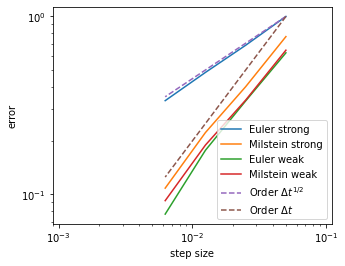

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

ax.loglog(step_size/np.array(steps), errors_euler_strong, label="Euler strong")
ax.loglog(step_size/np.array(steps), errors_milstein_strong, label="Milstein strong")
ax.loglog(step_size/np.array(steps), errors_euler_weak, label="Euler weak")
ax.loglog(step_size/np.array(steps), errors_milstein_weak, label="Milstein weak")

ax.loglog(step_size/np.array(steps), np.sqrt(step_size/np.array(steps)) / np.sqrt(step_size/np.array(steps[0])) * errors_euler_strong[0],"--", label=r"Order $\Delta t^{1/2}$")
ax.loglog(step_size/np.array(steps), (step_size/np.array(steps)) / (step_size/np.array(steps[0])) * errors_euler_strong[0],"--", label=r"Order $\Delta t$")
ax.legend()
ax.set_xlim([10**-3*0.9, 10**-1*1.1])

ax.set_xlabel("step size")
ax.set_ylabel("error")

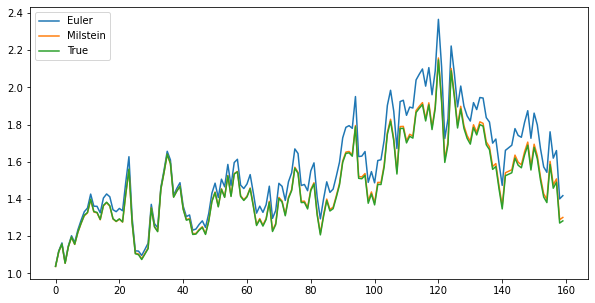

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(solutions_euler[0], label="Euler");
ax.plot(solutions_milstein[0], label="Milstein");
ax.plot(solutions_true[0], label="True");
ax.legend(loc="upper left")